## Lineær og Polynomisk Regression for Græskarpriser - Lektion 3

Indlæs de nødvendige biblioteker og datasættet. Konverter dataene til en dataframe, der indeholder et udsnit af dataene:

- Vælg kun græskar, der er prissat pr. tønde
- Konverter datoen til en måned
- Beregn prisen som gennemsnittet af højeste og laveste priser
- Konverter prisen, så den afspejler prissætningen pr. tøndemængde


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Et spredningsdiagram minder os om, at vi kun har månedsdata fra august til december. Vi har sandsynligvis brug for flere data for at kunne drage konklusioner på en lineær måde.


<AxesSubplot:xlabel='Month', ylabel='Price'>

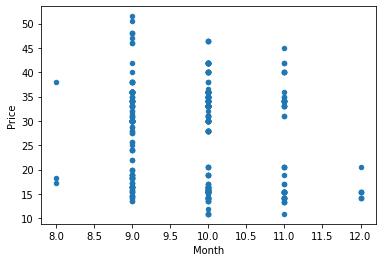

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

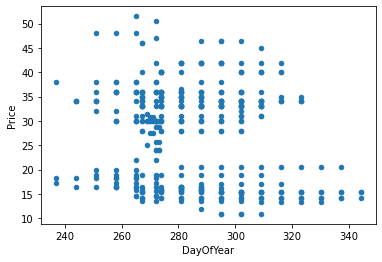

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Det ser ud til, at korrelationen er ret lille, men der er en anden vigtigere sammenhæng - fordi prisniveauerne i plottet ovenfor ser ud til at have flere tydelige klynger. Lad os lave et plot, der viser forskellige græskarsorter:


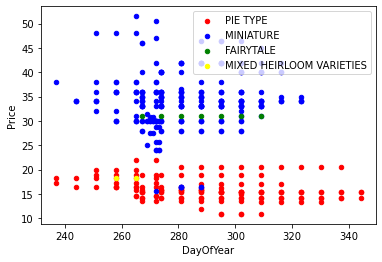

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

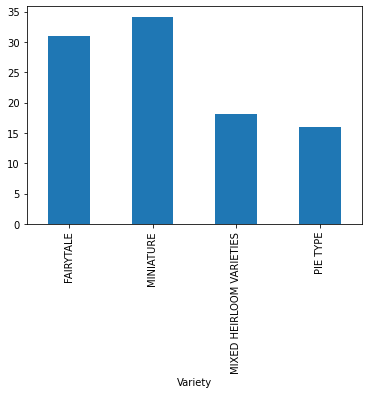

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

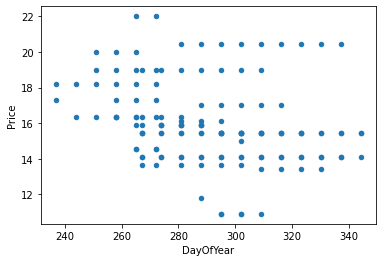

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Lineær regression

Vi vil bruge Scikit Learn til at træne en lineær regressionsmodel:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


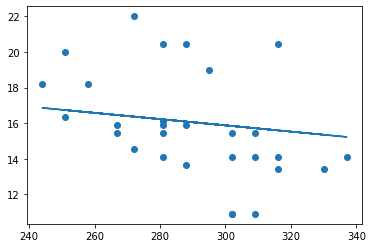

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Hældningen af linjen kan bestemmes ud fra lineære regressionskoefficienter:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

Vi kan bruge den trænede model til at forudsige prisen:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Polynomiel Regression

Nogle gange er forholdet mellem funktioner og resultater iboende ikke-lineært. For eksempel kan græskarpriser være høje om vinteren (måneder=1,2), derefter falde om sommeren (måneder=5-7) og derefter stige igen. Lineær regression er ikke i stand til at fange dette forhold præcist.

I dette tilfælde kan vi overveje at tilføje ekstra funktioner. En simpel måde er at bruge polynomier fra inputfunktionerne, hvilket vil resultere i **polynomiel regression**. I Scikit Learn kan vi automatisk forudberegne polynomielle funktioner ved hjælp af pipelines:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


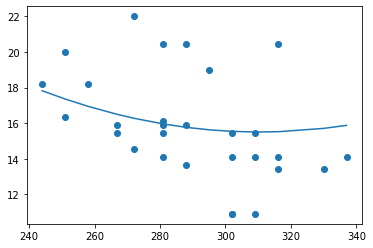

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Kodning af sorter

I en ideel verden ønsker vi at kunne forudsige priser for forskellige græskarsorter ved hjælp af den samme model. For at tage sorten i betragtning skal vi først konvertere den til numerisk form, eller **kode**. Der er flere måder, vi kan gøre det på:

* Simpel numerisk kodning, der opretter en tabel over forskellige sorter og derefter erstatter sortsnavnet med et indeks i den tabel. Dette er ikke den bedste idé til lineær regression, fordi lineær regression tager den numeriske værdi af indekset i betragtning, og den numeriske værdi sandsynligvis ikke korrelerer numerisk med prisen.
* One-hot kodning, som erstatter `Variety`-kolonnen med 4 forskellige kolonner, én for hver sort, der indeholder 1, hvis den tilsvarende række er af den givne sort, og 0 ellers.

Koden nedenfor viser, hvordan vi kan one-hot kode en sort:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Lineær regression på sort

Vi vil nu bruge den samme kode som ovenfor, men i stedet for `DayOfYear` vil vi bruge vores one-hot-encoded sort som input:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Vi kan også prøve at bruge andre funktioner på samme måde og kombinere dem med numeriske funktioner, såsom `Month` eller `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Polynomiel Regression

Polynomiel regression kan også bruges med kategoriske funktioner, der er one-hot-enkodede. Koden til at træne polynomiel regression vil grundlæggende være den samme, som vi har set ovenfor.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Ansvarsfraskrivelse**:  
Dette dokument er blevet oversat ved hjælp af AI-oversættelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selvom vi bestræber os på nøjagtighed, skal du være opmærksom på, at automatiserede oversættelser kan indeholde fejl eller unøjagtigheder. Det originale dokument på dets oprindelige sprog bør betragtes som den autoritative kilde. For kritisk information anbefales professionel menneskelig oversættelse. Vi er ikke ansvarlige for eventuelle misforståelser eller fejltolkninger, der måtte opstå som følge af brugen af denne oversættelse.
